In [6]:
!pip install tensorflow-datasets



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
import tens

In [10]:
path = "file:///D:/ML Learning/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", path,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [12]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [13]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['csharp', 'java', 'javascript', 'python']

In [14]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
  print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [16]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [17]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to csharp
Label 1 corresponds to java


In [18]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [20]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [21]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [22]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [23]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [24]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [25]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public

In [26]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [28]:
embedding_dim = 16

In [29]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='softmax')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [43]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7406 - loss: 0.7944 - val_accuracy: 0.7465 - val_loss: 0.7747
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7503 - loss: 0.7651 - val_accuracy: 0.7551 - val_loss: 0.7521
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7591 - loss: 0.7436 - val_accuracy: 0.7634 - val_loss: 0.7325
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7655 - loss: 0.7255 - val_accuracy: 0.7682 - val_loss: 0.7161
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7710 - loss: 0.7094 - val_accuracy: 0.7733 - val_loss: 0.7010
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7755 - loss: 0.6950 - val_accuracy: 0.7774 - val_loss: 0.6872
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7794 - loss: 0.6816 - val_accuracy: 0.7816 - val_loss: 0.6743
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7841 - loss: 0.6686 - val_accu

In [44]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8215 - loss: 0.5514
Loss:  tf.Tensor(0.82060796, shape=(), dtype=float32)
Accuracy:  tf.Tensor(0.5517789, shape=(), dtype=float32)


In [45]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

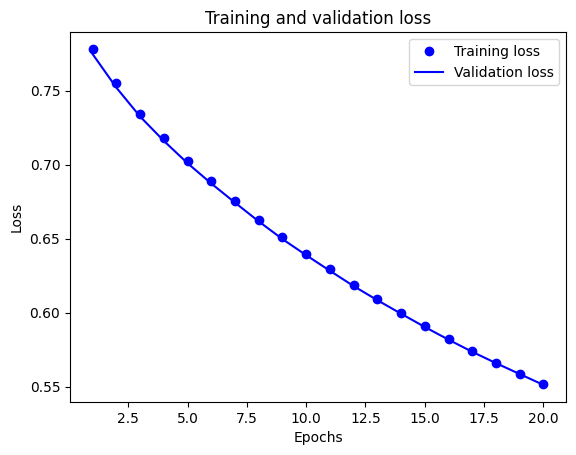

In [46]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [47]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)


In [48]:

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds)
print(metrics)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7805 - loss: 1.0156
[1.014590859413147, 0.7818750143051147]


In [64]:
examples = tf.constant([
  "blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public static void main(string[] args) {.        scanner in = new scanner(system.in);.        int t,n,c,m,r;.            t = in.nextint();.            while(t--&gt;0){.             n = in.nextint();.            c = in.nextint();.             m = in.nextint();.                r=n/c;.                cc=r;..                    while(r&gt;=m){.                        cc=cc+r/m;.                        r=r%m+r/m;.                    }..                system.out.println(cc); .            }..    }.}...my solution:..import blank.io.*;.import blank.util.*;..public class solution {..    public static void main(string[] args) {..        scanner sc = new scanner(system.in);.        int t = integer.parseint(sc.nextline());    //t = number of test cases.        int[][] tc = readinput(sc, t);              //tc[t][0] = money. tc[t][1] = price. tc[t][2] = wrappers per free bar..        for (int i = 0; i&lt;t; i++){                  //loop for all test cases.            int choc = calcchoc(tc,i);              //work out how much choc can be bought.            system.out.println(choc);               //print result for the test case.        }.    }.    //calculate how much choc he can buy with m $ at p price with w wrappers needed for a free bar.    public static int calcchoc(int[][] tc,int i){..        int m = tc[i][0];       //money he has.        int p = tc[i][1];       //price of choc.        int w = tc[i][2];       //wrappers per free bar..        int bars = m/p;         //how many bars he can buy initially.        int wrappers = bars;    //each bar is a wrapper from initial purpose..        //loop to turn in all wrappers while it is possible to do so.        while (w&lt;=wrappers){..            int barsfromturnin = wrappers/w;                //bars from turning in current wrappers..            bars = bars + barsfromturnin;                   //new bar count.            wrappers = wrappers - (barsfromturnin * (w-1)); //wrapper count reduced by amount of wrappers turned in -1 wrapper per bar recieved from turn in...            if (w==1){ /",
  "blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    public static void main(string[] args) {.        scanner in = new scanner(system.in);.        int t,n,c,m,r;.            t = in.nextint();.            while(t--&gt;0){.             n = in.nextint();.            c = in.nextint();.             m = in.nextint();.                r=n/c;.                cc=r;..                    while(r&gt;=m){.                        cc=cc+r/m;.                        r=r%m+r/m;.                    }..                system.out.println(cc); .            }..    }.}...my solution:..import blank.io.*;.import blank.util.*;..public class solution {..    public static void main(string[] args) {..        scanner sc = new scanner(system.in);.        int t = integer.parseint(sc.nextline());    //t = number of test cases.        int[][] tc = readinput(sc, t);              //tc[t][0] = money. tc[t][1] = price. tc[t][2] = wrappers per free bar..        for (int i = 0; i&lt;t; i++){                  //loop for all test cases.            int choc = calcchoc(tc,i);              //work out how much choc can be bought.            system.out.println(choc);               //print result for the test case.        }.    }.    //calculate how much choc he can buy with m $ at p price with w wrappers needed for a free bar.    public static int calcchoc(int[][] tc,int i){..        int m = tc[i][0];       //money he has.        int p = tc[i][1];       //price of choc.        int w = tc[i][2];       //wrappers per free bar..        int bars = m/p;         //how many bars he can buy initially.        int wrappers = bars;    //each bar is a wrapper from initial purpose..        //loop to turn in all wrappers while it is possible to do so.        while (w&lt;=wrappers){..            int barsfromturnin = wrappers/w;                //bars from turning in current wrappers..            bars = bars + barsfromturnin;                   //new bar count.            wrappers = wrappers - (barsfromturnin * (w-1)); //wrapper count reduced by amount of wrappers turned in -1 wrapper per bar recieved from turn in...            if (w==1){ /",
 """List of more derived objects gioves compile error in a C# interface implementation [duplicate] public interface IConfigurationResult
{
    public int ItemId { get; }

    public string ItemCode { get; }

    public IList<IConfigurationVariable> Variables { get; }
}"""
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[0.1751961 , 0.47490162, 0.17495115, 0.17495115],
       [0.1751961 , 0.47490162, 0.17495115, 0.17495115],
       [0.3296599 , 0.2919289 , 0.1891338 , 0.18927735]], dtype=float32)